In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketdata_sample.csv', 'news_sample.csv']


In [99]:
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from kaggle.competitions import twosigmanews

In [100]:
import lightgbm as lgb
import random
from datetime import datetime, date
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import time

In [101]:
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()


Exception: You can only make one environment for this competition.

**Market data preprocessing**

In [ ]:
def test_period(df):
    
    df = df.loc[df['time'] >= date(2019, 1, 8)]
    df = df.loc[df['time']<date(2019, 5, 9)]
    
    return df

def test_market_prep(df):
   # Shift -11 days gives us returnsOpenNextMktres10
    df['returnsOpenNextMktres10'] = df.groupby(['assetCode'])['returnsOpenPrevMktres10'].shift(-11).fillna(0)
    
    df['time'] = df['time'].dt.date
    
    df = df.loc[df['time']>=date(2009, 1, 1)]
    df = test_period(df)
    return df

In [ ]:
market_obs_df = None
pred_df = None
news_test_df = None

for (m_df, n_df, predictions_template_df) in env.get_prediction_days():
    env.predict(predictions_template_df)
    predictions_template_df['time'] = m_df.time.min()
    m_df = m_df[m_df['time'] > "2019-01-01"]
    n_df = n_df[n_df['time'] > "2019-01-01"]
    
    if m_df is not None:
        if market_obs_df is None:
            market_obs_df = m_df
            pred_df = predictions_template_df
        else:
            market_obs_df = market_obs_df.append(m_df, ignore_index=True)
            pred_df = pred_df.append(predictions_template_df, ignore_index=True)
            
    if n_df is not None:
        if news_test_df is None:
            news_test_df = n_df
        else:
            news_test_df = news_test_df.append(n_df, ignore_index=True)

In [ ]:
news_test_df

In [ ]:
test_df = test_market_prep(market_obs_df)

In [ ]:
test_df

In [ ]:
def preprocess_train_market(market_data):
    market_cols = ['time', 'assetCode', 'volume', 'returnsOpenPrevMktres1', 'returnsOpenPrevMktres10', 'returnsOpenNextMktres10']
    market_data = market_data[market_cols]
    
    market_data['time'] = market_data['time'].dt.date
    market_data = market_data.loc[market_data['time']>=date(2009, 1, 1)]
    
    market_data['moving'] = market_data.groupby(['assetCode'])['volume'].transform(lambda x: x.rolling(10, 10).mean())
    market_data['volume_dev'] = market_data['volume']/market_data['moving']
    
    #market_data = market_data.dropna(subset = ['volume_dev'])
    market_data = market_data.drop(columns = ['moving', 'volume'])
    
    
    return market_data

def preprocess_test_market(market_data):
    market_cols = ['time', 'assetCode', 'volume', 'returnsOpenPrevMktres1', 'returnsOpenPrevMktres10', 'returnsOpenNextMktres10']
    market_data = market_data[market_cols]
    
    market_data['moving'] = market_data.groupby(['assetCode'])['volume'].transform(lambda x: x.rolling(10, 10).mean())
    market_data['volume_dev'] = market_data['volume']/market_data['moving']
    
    #market_data = market_data.dropna(subset = ['returnsOpenPrevMktres10', 'volume_dev'])
    market_data = market_data.drop(columns = ['moving', 'volume'])
    
    
    return market_data

In [ ]:
market_train = preprocess_train_market(market_train_df)
market_test = preprocess_test_market(test_df)
market_train.head()

**News data preprocessing**

In [ ]:
def preprocess_news(news_df):
    
    
    # Factorize categorical columns
    for col in ['headlineTag', 'provider', 'sourceId']:
        news_df[col], uniques = pd.factorize(news_df[col])
        del uniques
    
    # Remove {} and '' from assetCodes column
    news_df['assetCodes'] = news_df['assetCodes'].apply(lambda x: x[1:-1].replace("'", ""))
    
    # Filter for asset-specific data
    news_df[news_df['marketCommentary'] == False]
    #news_df[news_df['urgency'] == 3]
    
    news_df['shareWordCount'] = news_df['sentimentWordCount'] / news_df['wordCount']
    
    # Leave only main columns
    news_cols = ['time', 'sourceId','assetCodes', 'shareWordCount', 'sentimentPositive', 'volumeCounts24H', 'volumeCounts7D', 'headline']
    news_df = news_df[news_cols]
    
    # Filter for values between 2009 and 2018
    news_df['time'] = news_df['time'].dt.date
    news_df = news_df.loc[news_df['time']>=date(2009, 1, 1)]
    
    return news_df

news_train_df = preprocess_news(news_train_df)

news_test_df = preprocess_news(news_test_df)
news_test_df = test_period(news_test_df)
news_train_df.tail()

In [ ]:
news_train_df.head()

In [ ]:
def unstack_asset_codes(news_df):
    codes = []
    indexes = []
    for i, values in news_df['assetCodes'].iteritems():
        explode = values.split(", ")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df

index_train_df = unstack_asset_codes(news_train_df)
index_test_df = unstack_asset_codes(news_test_df)
index_train_df.head()

In [ ]:
def merge_news_on_index(news_train_df, index_df):
    news_train_df['news_index'] = news_train_df.index.copy()

    # Merge news on unstacked assets
    news_unstack = index_df.merge(news_train_df, how='left', on='news_index')
    news_unstack.drop(['news_index', 'assetCodes'], axis=1, inplace=True)
    return news_unstack

def aggregate_news(news_df):
    news_df = news_df.groupby(['assetCode', 'time'], as_index=False).agg('mean')

    return news_df


news_train_unstack = merge_news_on_index(news_train_df, index_train_df)
del news_train_df, index_train_df

news_test_unstack = merge_news_on_index(news_test_df, index_test_df)
del news_test_df, index_test_df

news_train_unstack.head()

Let's check whether there are several records that belong to the same asset at the same day

In [ ]:
df = news_train_unstack.loc[news_train_unstack['time'] <= date(2011, 1, 1)]
group = df.groupby(['assetCode', 'time']).size()
group.head()

Thus, the data must be aggregated at the day level

In [ ]:
news_train = aggregate_news(news_train_unstack)
news_test = aggregate_news(news_test_unstack)

news_train.head()

In [ ]:
df = news_train.loc[news_train['time'] <= date(2011, 1, 1)]
group = df.groupby(['assetCode', 'time']).size()
group.head()

**Merge of news data with market data**

In [ ]:
x_train = market_train.merge(news_train, how='left', on=['assetCode', 'time'])
x_test = market_test.merge(news_test, how='left', on=['assetCode', 'time'])

x_train = x_train[x_train['returnsOpenNextMktres10'] <= np.percentile(x_train['returnsOpenNextMktres10'], 99)]
x_train = x_train[x_train['returnsOpenNextMktres10'] >= np.percentile(x_train['returnsOpenNextMktres10'], 1)]

In [ ]:
y_test = x_test[['returnsOpenNextMktres10', 'time']]
y_train = x_train[['returnsOpenNextMktres10', 'time']]


#del market_train, news_agg
gc.collect()

x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

x_train.head(10)

In [ ]:
def features_eng(data):
    
    
    data['moving'] = data.groupby(['assetCode'])['volumeCounts24H'].transform(lambda x: x.rolling(10, 10).mean())
    data['volumeCounts24H_dev'] = (data['volumeCounts24H']/data['moving']) - 1
    data = data.drop(columns = ['moving'])
    
    data['moving'] = data.groupby(['assetCode'])['volumeCounts7D'].transform(lambda x: x.rolling(10, 10).mean())
    data['volumeCounts7D_dev'] = (data['volumeCounts7D']/data['moving']) - 1
    data = data.drop(columns = ['moving'])
    
    data['moving'] = data.groupby(['assetCode'])['sentimentPositive'].transform(lambda x: x.rolling(10, 10).mean())
    data['sentimentPositive_dev'] = (data['sentimentPositive']/data['moving']) - 1
    

    data = data.drop(columns = ['moving', 'sentimentPositive'])
    
    
    result = pd.DataFrame({'time' : data['time'], '24H' : data["volumeCounts24H"], '7D' : data['volumeCounts7D']})
    max_values = result.groupby('time').max().values
    dates = pd.DataFrame(data['time'].unique(), columns = ['date'])
    merged_df = pd.DataFrame(np.concatenate((max_values, dates), axis = 1), columns = ['max_24H', 'max_7D', 'time'])
    
    data = merged_df.merge(data, how='left', on=['time'])
    
    data['max_24H'] = pd.to_numeric(data['max_24H'], errors='coerce').fillna(0)
    data['max_7D'] = pd.to_numeric(data['max_7D'], errors='coerce').fillna(0)
    
    data['hype24H'] = data['volumeCounts24H']/data['max_24H']
    data['hype7D'] = data['volumeCounts7D']/data['max_7D']
    
    
    data['volumeCounts24H_dev'] = data['volumeCounts24H_dev'].fillna(0)
    data['volumeCounts7D_dev'] = data['volumeCounts7D_dev'].fillna(0)
    data['sentimentPositive_dev'] = data['sentimentPositive_dev'].fillna(0)
    
    data = data.drop(columns = ['volumeCounts7D', 'volumeCounts24H', 'max_7D', 'max_24H'])
    data = data.dropna(subset = ['returnsOpenPrevMktres10'])
    
    return data

In [ ]:
x_test_original = features_eng(x_test)

x_train = features_eng(x_train)
x_test = features_eng(x_test)



**LGBM And XGB Classifier.Train and Validation**

In [ ]:
num_target = x_train.returnsOpenNextMktres10.astype('float32')
bin_target = (x_train.returnsOpenNextMktres10 >= 0).astype('int8')

# Drop columns that are not features
x_train.drop(['sourceId', 'assetCode', 'time', 'returnsOpenNextMktres10'], axis=1, inplace=True)
x_test.drop(['sourceId', 'assetCode', 'time', 'returnsOpenNextMktres10'], axis=1, inplace=True)
gc.collect()

In [125]:
bin_y_test = (y_test.returnsOpenNextMktres10 >= 0).astype('int8')

In [ ]:
train_index, validation_index = train_test_split(x_train.index.values, test_size=0.1, shuffle=False)

In [ ]:
def evaluate_model_LGBM(df, target, train_index, validation_index, params):
    params['n_jobs'] = 2  # Use 2 cores/threads
    model = LGBMClassifier(**params)
    model.fit(df.iloc[train_index], target.iloc[train_index])
    return log_loss(target.iloc[validation_index], model.predict_proba(df.iloc[validation_index]))

def evaluate_model_XGB(df, target, train_index, validation_index, params):
    params['n_jobs'] = 2  # Use 2 cores/threads
    model = XGBClassifier(**params)
    model.fit(df.iloc[train_index], target.iloc[train_index])
    return log_loss(target.iloc[validation_index], model.predict_proba(df.iloc[validation_index]))

In [ ]:
main_params = {'learning_rate': 0.15,
 'num_leaves': 72,
 'n_estimators': 600,
 'min_child_samples': 30,
 'colsample_bytree': 1.0,
 'subsample': 0.95,
 'reg_alpha': 0.1,
 'reg_lambda': 0.8,
 'n_jobs': 2}

In [ ]:
#score = evaluate_model_LGBM(x_train, bin_target, train_index, validation_index, main_params)
#score

In [ ]:
#log_loss(bin_target.iloc[train_index], model.predict_proba(df.iloc[validation_index]))

In [ ]:
#score = evaluate_model_XGB(x_train, bin_target, train_index, validation_index, main_params)
#score

param_grid = {
    'learning_rate': [0.2, 0.15, 0.1, 0.05, 0.02, 0.01],
    'num_leaves': [i for i in range(12, 90, 6)],
    'n_estimators': [50, 200, 400, 600, 800],
    'min_child_samples': [i for i in range(10, 100, 10)],
    'colsample_bytree': [0.8, 0.9, 0.95, 1],
    'subsample': [0.8, 0.9, 0.95, 1],
    'reg_alpha': [0.1, 0.2, 0.4, 0.6, 0.8],
    'reg_lambda': [0.1, 0.2, 0.4, 0.6, 0.8],
}

best_eval_score = 0
for i in range(100):  # Hundred runs
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    score = evaluate_model_LGBM(x_train, bin_target, train_index, validation_index, params)
    if score < best_eval_score or best_eval_score == 0:
        best_eval_score = score
        best_params = params
print("Best evaluation logloss", best_eval_score)

In [ ]:
clf = LGBMClassifier(**main_params)
clf.fit(x_train.iloc[train_index], bin_target.iloc[train_index])
predict_proba = clf.predict_proba(x_train.iloc[validation_index])

In [ ]:
len(predict_proba)

In [ ]:
def column(matrix, i):
    return [row[i] for row in matrix]

def custom_metric(predict_proba, y_train):
    predict_proba = pd.DataFrame(column(predict_proba, 1))
    y = predict_proba*2 - 1
    x = y * y_train.iloc[validation_index].returnsOpenNextMktres10.values.reshape((len(predict_proba), 1))
    merge = pd.DataFrame(np.concatenate((x, y_train.iloc[validation_index]), axis = 1), columns = ["conf_val*returns", "col", "time"])
    result = pd.DataFrame({'day' : merge['time'], 'x' : merge["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    
    return np.mean(x_t) / np.std(x_t)

In [ ]:
custom_metric(predict_proba, y_train)

In [ ]:
def plot_x_t_val(predict_proba, y_train):
    predict_proba = pd.DataFrame(column(predict_proba, 1))
    y = predict_proba*2 - 1
    x = y * y_train.iloc[validation_index].returnsOpenNextMktres10.values.reshape((len(predict_proba), 1))
    merge = pd.DataFrame(np.concatenate((x, y_train.iloc[validation_index]), axis = 1), columns = ["conf_val*returns", "col", "time"])
    result = pd.DataFrame({'day' : merge['time'], 'x' : merge["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    
    x_axis = result['day'].unique()
    plt.plot_date(x_axis, x_t, linestyle = 'solid', marker = 'None', fmt = 'M')
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    return plt.show()

In [ ]:
plot_x_t_val(predict_proba, y_train)

In [ ]:
lgb.plot_importance(clf, max_num_features=10)

In [ ]:
corr_train = x_train.corr()
corr_train.style.background_gradient(cmap='coolwarm')

In [ ]:
corr_test = x_test.corr()
corr_test.style.background_gradient(cmap='coolwarm')

**LGBM Classifier Test**

In [ ]:
predict_pro = clf.predict_proba(x_test)

In [ ]:
#2018 - 430823

def cust_metric(predict_proba, y_values):
    predict_proba = pd.DataFrame(column(predict_proba, 1))
    y = predict_proba*2 - 1
    x = y * y_values.returnsOpenNextMktres10.values.reshape((173938, 1))
    merge = pd.DataFrame(np.concatenate((x, y_values), axis = 1), columns = ["conf_val*returns", "col", "time"])
    result = pd.DataFrame({'day' : merge['time'], 'x' : merge["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    return np.mean(x_t)/ np.std(x_t)

In [ ]:
cust_metric(predict_pro, y_test)

In [ ]:
def plot_x_t_test(predict_proba, y_values):
    predict_proba = pd.DataFrame(column(predict_proba, 1))
    y = predict_proba*2 - 1
    x = y * y_values.returnsOpenNextMktres10.values.reshape((173938, 1))
    merge = pd.DataFrame(np.concatenate((x, y_values), axis = 1), columns = ["conf_val*returns", "col", "time"])
    result = pd.DataFrame({'day' : merge['time'], 'x' : merge["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    
    x_axis = result['day'].unique()
    plt.plot_date(x_axis, x_t, linestyle = 'solid', marker = 'None', fmt = 'M')
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)

    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    return plt.show()

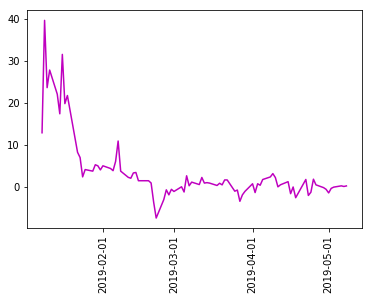

In [102]:
plot_x_t_test(predict_pro, y_test)

In [127]:
log_loss(bin_y_test, clf.predict_proba(x_test))

0.676570704518276

In [135]:
clf.score(x_test, bin_y_test)

0.5718301923673953

**Catboost**

In [ ]:
modelstart= time.time()
cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.15,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
x_train.iloc[train_index], bin_target.iloc[train_index]
cb_model.fit(x_train.iloc[train_index], bin_target.iloc[train_index],
             eval_set=(x_train.iloc[validation_index],bin_target.iloc[validation_index]),
             use_best_model=True)

In [ ]:
catpred = cb_model.predict(x_test)

In [ ]:
def cat_metric(predict_proba, y_values):
    predict_proba = np.expand_dims(predict_proba, axis=1)
    predict_proba = pd.DataFrame(column(predict_proba, 0))
    y = predict_proba*2 - 1
    
    x = y * y_values.returnsOpenNextMktres10.values.reshape((173938, 1))
    merge = pd.DataFrame(np.concatenate((x, y_values), axis = 1), columns = ["conf_val*returns", "col", "time"])
    result = pd.DataFrame({'day' : merge['time'], 'x' : merge["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    return np.mean(x_t) / np.std(x_t)

In [ ]:
cat_metric(catpred, y_test)

In [ ]:
def plot_cat_test(predict_proba, y_values):
    predict_proba = np.expand_dims(predict_proba, axis=1)
    predict_proba = pd.DataFrame(column(predict_proba, 0))
    y = predict_proba*2 - 1
    
    x = y * y_values.returnsOpenNextMktres10.values.reshape((173938, 1))
    merge = pd.DataFrame(np.concatenate((x, y_values), axis = 1), columns = ["conf_val*returns", "col", "time"])
    result = pd.DataFrame({'day' : merge['time'], 'x' : merge["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    
    x_axis = result['day'].unique()
    plt.plot_date(x_axis, x_t, linestyle = 'solid', marker = 'None', fmt = 'M')
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)

    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    return plt.show()

In [ ]:
plot_cat_test(catpred, y_test)

In [129]:
log_loss(bin_y_test, cb_model.predict(x_test))

0.67777720155086

In [134]:
cb_model.score(x_test, bin_y_test)

0.49236248264413096

In [ ]:
cb_model.get_feature_importance()

**Logistic regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [ ]:
logreg.fit(x_train, bin_target)
log_proba_pred = logreg.predict_proba(x_test)

In [ ]:
cust_metric(log_proba_pred, y_test)

In [ ]:
plot_x_t_test(log_proba_pred, y_test)

In [130]:
log_loss(bin_y_test, logreg.predict_proba(x_test))

0.6839869156165957

In [133]:
logreg.score(x_test, bin_y_test)

0.578470489484759

**Linear Regression Train and Validation**

In [ ]:
reg = LinearRegression().fit(x_train.iloc[train_index], num_target.iloc[train_index])
reg.score(x_train.iloc[train_index], num_target.iloc[train_index])

In [ ]:
x_train.iloc[train_index].head()

In [103]:
reg.coef_

array([-6.98184538e-02,  8.43400742e-02,  1.12281744e-04, -7.68682321e-04,
        2.22306226e-05,  4.17021149e-05,  4.33368901e-05, -2.95427634e-03,
       -1.95761992e-03])

In [ ]:
sklearn.feature_selection.f_regression(x_train.iloc[train_index], num_target.iloc[train_index])

In [ ]:
lin_y_predict = pd.DataFrame(reg.predict(x_train.iloc[validation_index]))
y_validation = y_train.iloc[validation_index]

In [ ]:
merge_lin = pd.DataFrame(np.concatenate((lin_y_predict, y_validation), axis = 1), columns = ['predictions', 'returns', 'day'])
merge_lin.head()

In [ ]:
result = pd.DataFrame({'day' : merge_lin['day'], 'x' : merge_lin["predictions"]})

In [ ]:
min_x_t = result.groupby('day').min().values
max_x_t = result.groupby('day').max().values


In [ ]:
df_dates = pd.DataFrame(y_validation['time'].unique(), columns = ['date'])
merged_df = pd.DataFrame(np.concatenate((min_x_t, max_x_t, df_dates), axis = 1), columns = ['min_prediction', 'max_prediction', 'day'])
merged_df.head()

In [ ]:
result_merged = merged_df.merge(merge_lin, how='left', on=['day'])
result_merged.head()

In [ ]:
def conf_val_prediction(df):
    if df['predictions'] > 0:
        df['conf_val'] = df['predictions']/df['max_prediction']
    else:
        df['conf_val'] = -df['predictions']/df['min_prediction']
    
    df['conf_val*returns'] = df['conf_val'] * df['returns']
    
    return df


def lin_metric(df):
    result = pd.DataFrame({'day' : df['day'], 'x' : df["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    return np.mean(x_t) / np.std(x_t)

In [ ]:
lin_df = result_merged.apply(conf_val_prediction, axis=1)
lin_df.head()

In [ ]:
lin_metric(lin_df)

In [ ]:
def plot_lin(df):
    result = pd.DataFrame({'day' : df['day'], 'x' : df["conf_val*returns"]})
    x_t = result.groupby('day').sum().values
    
    x_axis = result['day'].unique()
    plt.plot_date(x_axis, x_t, linestyle = 'solid', marker = 'None', fmt = 'M')
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)

    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    return plt.show()

In [ ]:
plot_lin(lin_df)

**Linear Regression Test**

In [ ]:
test_lin_y_predict = pd.DataFrame(reg.predict(x_test))

test_merge_lin = pd.DataFrame(np.concatenate((test_lin_y_predict, y_test), axis = 1), columns = ['predictions', 'returns', 'day'])

test_result = pd.DataFrame({'day' : test_merge_lin['day'], 'x' : test_merge_lin["predictions"]})

test_min_x_t = test_result.groupby('day').min().values
test_max_x_t = test_result.groupby('day').max().values

test_df_dates = pd.DataFrame(y_test['time'].unique(), columns = ['date'])
test_merged_df = pd.DataFrame(np.concatenate((test_min_x_t, test_max_x_t, test_df_dates), axis = 1), columns = ['min_prediction', 'max_prediction', 'day'])

test_result_merged = test_merged_df.merge(test_merge_lin, how='left', on=['day'])

test_lin_df = test_result_merged.apply(conf_val_prediction, axis=1)

lin_metric(test_lin_df)

In [115]:
test_lin_y_predict.columns = ['predictions']
reg.score(x_test, y_test['returnsOpenNextMktres10'])

-0.017554786346516194

In [ ]:
plot_lin(test_lin_df)

In [ ]:
x_test_original = x_test_original[['assetCode', 'time', 'returnsOpenNextMktres10']]
x_test_original.columns = ['assetCode', 'day', 'returns']

asset_predictions = x_test_original.merge(test_lin_df, how='left', on=['returns', 'day'])
asset_predictions = asset_predictions[['assetCode', 'day', 'returns', 'predictions']]

In [ ]:
asset_list = ['AAPL.O', 'GM.N', 'FB.O']
asset_predictions = asset_predictions[asset_predictions['assetCode'].isin(asset_list)]

In [ ]:
asset_predictions_apple = asset_predictions[asset_predictions['assetCode'] == 'AAPL.O']
asset_predictions_gm = asset_predictions[asset_predictions['assetCode'] == 'GM.N']
asset_predictions_fb = asset_predictions[asset_predictions['assetCode'] == 'FB.O']

Apple

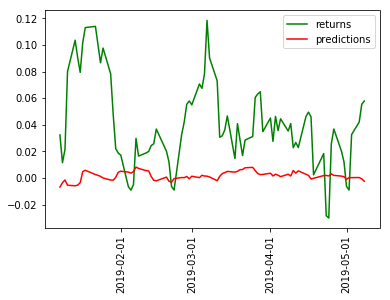

In [121]:
plt.plot_date(asset_predictions_apple['day'], asset_predictions_apple['returns'], linestyle = 'solid', marker = 'None',
              fmt = 'M', color = 'green')
plt.plot_date(asset_predictions_apple['day'], asset_predictions_apple['predictions'], linestyle = 'solid', marker = 'None',
              fmt = 'M', color = 'red')
plt.legend()
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())

Facebook

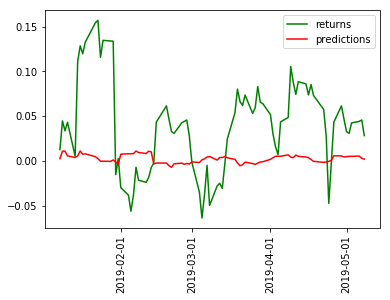

In [122]:
plt.plot_date(asset_predictions_fb['day'], asset_predictions_fb['returns'], linestyle = 'solid', marker = 'None',
              fmt = 'M', color = 'green')
plt.plot_date(asset_predictions_fb['day'], asset_predictions_fb['predictions'], linestyle = 'solid', marker = 'None',
              fmt = 'M', color = 'red')
plt.legend()
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())

General Motors

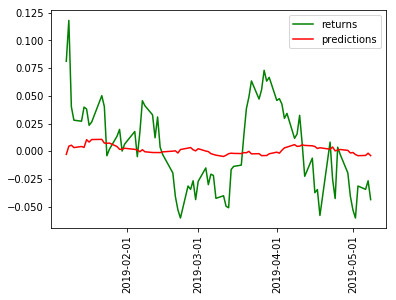

In [123]:
plt.plot_date(asset_predictions_gm['day'], asset_predictions_gm['returns'], linestyle = 'solid', marker = 'None',
              fmt = 'M', color = 'green')
plt.plot_date(asset_predictions_gm['day'], asset_predictions_gm['predictions'], linestyle = 'solid', marker = 'None',
              fmt = 'M', color = 'red')
plt.legend()
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())